In [1]:
import os 
import cv2
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import PIL
import pathlib

2022-09-04 08:40:39.374531: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/amadon/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-09-04 08:40:39.374718: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
BATCH_SIZE = 32
IMG_SIZE = (150, 150)
INPUT_SHAPE = (150, 150, 3)

train_dir = pathlib.Path('data_dir/train/')
test_dir = pathlib.Path('data_dir/test/')
val_dir = pathlib.Path('data_dir/valid/')

category = []
for folder in os.listdir(train_dir):
    category.append(folder)
    
num_classes = len(category)

In [3]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    horizontal_flip=True,
    fill_mode='nearest'
    )
test_datagen=ImageDataGenerator(rescale=1./255)

# VGG16 Model

In [4]:
train_dataset = test_datagen.flow_from_directory(train_dir,
                                                batch_size=BATCH_SIZE,
                                                target_size=IMG_SIZE)

Found 9285 images belonging to 75 classes.


In [5]:
test_dataset = test_datagen.flow_from_directory(test_dir,
                                                batch_size=BATCH_SIZE,
                                                target_size=IMG_SIZE)

Found 375 images belonging to 75 classes.


In [6]:
val_dataset = test_datagen.flow_from_directory(val_dir,
                                                batch_size=BATCH_SIZE,
                                                target_size=IMG_SIZE)

Found 375 images belonging to 75 classes.


In [7]:
vgg16base_model = VGG16(
    weights = "imagenet",
    include_top=False, 
    input_shape = INPUT_SHAPE
    ) 

2022-09-04 08:40:45.060761: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/amadon/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-09-04 08:40:45.063469: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-04 08:40:45.064654: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (amadon-virtual-machine): /proc/driver/nvidia/version does not exist
2022-09-04 08:40:45.066777: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
vgg16base_model.trainable = False

In [9]:
vgg16base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [10]:
model = vgg16base_model
x = model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
predictions = tf.keras.layers.Dense(num_classes, activation="softmax")(x)   

vgg16_model = tf.keras.Model(
    inputs = model.input, 
    outputs = predictions)

vgg16_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  

In [11]:
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [12]:
initial_epochs = 10

simplevgg16_history = vgg16_model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=val_dataset,
    verbose=1,
)

Epoch 1/10
291/291 [==============================] - 570s 2s/step - loss: 1.9401 - accuracy: 0.5387 - val_loss: 0.8772 - val_accuracy: 0.7813
Epoch 2/10
291/291 [==============================] - 504s 2s/step - loss: 0.5708 - accuracy: 0.8558 - val_loss: 0.6020 - val_accuracy: 0.8347
Epoch 3/10
291/291 [==============================] - 481s 2s/step - loss: 0.2835 - accuracy: 0.9298 - val_loss: 0.5154 - val_accuracy: 0.8587
Epoch 4/10
291/291 [==============================] - 503s 2s/step - loss: 0.1384 - accuracy: 0.9720 - val_loss: 0.4844 - val_accuracy: 0.8773
Epoch 5/10
291/291 [==============================] - 509s 2s/step - loss: 0.0721 - accuracy: 0.9892 - val_loss: 0.5013 - val_accuracy: 0.8800
Epoch 6/10
291/291 [==============================] - 516s 2s/step - loss: 0.0439 - accuracy: 0.9922 - val_loss: 0.5925 - val_accuracy: 0.8400
Epoch 7/10
291/291 [==============================] - 508s 2s/step - loss: 0.0519 - accuracy: 0.9907 - val_loss: 0.7779 - val_accuracy: 0.8080

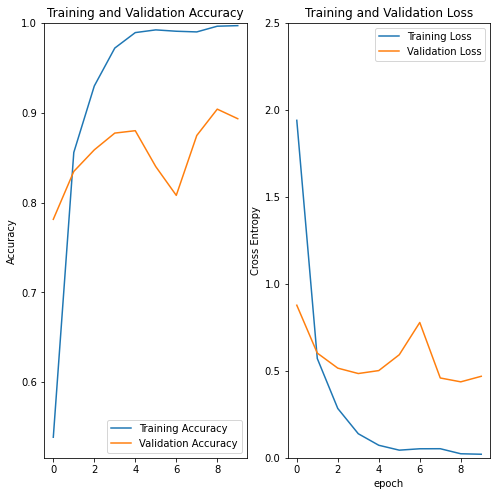

In [13]:
acc = simplevgg16_history.history['accuracy']
val_acc = simplevgg16_history.history['val_accuracy']

loss = simplevgg16_history.history['loss']
val_loss = simplevgg16_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [14]:
print("[INFO] Calculating model accuracy")
scores = vgg16_model.evaluate(test_dataset)
print(f"Test Accuracy: {scores[1]*100}%")

[INFO] Calculating model accuracy
12/12 [==============================] - 20s 2s/step - loss: 0.4506 - accuracy: 0.8880
Test Accuracy: 88.80000114440918%


1/1 [==============================] - 0s 279ms/step
This image most likely belongs to ADONIS with a 88.80 percent confidence.
ADONIS


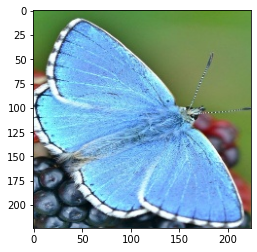

In [15]:
classes=list(train_dataset.class_indices.keys())
# Pre-Processing test data same as train data.
def prepare(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
    x = tf.keras.utils.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
img_url=r'data_dir/6 images/4.jpg'
result_basevgg16= vgg16_model.predict([prepare(img_url)])
butterfly=tf.keras.utils.load_img(img_url)
plt.imshow(butterfly)

classresult=np.argmax(result_basevgg16,axis=1)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(classes[classresult[0]], 100 * np.max(scores))
)
print(classes[classresult[0]])

In [16]:
vgg16_model.save('simplevgg16_model.h5')

In [17]:
train_dataset = test_datagen.flow_from_directory(train_dir,
                                                batch_size=BATCH_SIZE,
                                                target_size=IMG_SIZE)

Found 9285 images belonging to 75 classes.


In [18]:
inputs = tf.keras.Input(shape=INPUT_SHAPE)
x = vgg16base_model(inputs, training=False)
x = layers.Dropout(0.4)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
predictions = layers.Dense(num_classes, activation="softmax")(x)   

augvgg16_model = tf.keras.Model(
    inputs, 
    outputs = predictions)

base_learning_rate = 0.0005

augvgg16_model.compile(loss='categorical_crossentropy', 
                       optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
                       metrics=['accuracy'])  

In [19]:
augvgg16_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 4, 4, 512)         0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 75)                19275     
                                                                 
Total params: 16,831,371
Trainable params: 2,116,683
Non-tr

In [20]:
augvgg16_history = augvgg16_model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=val_dataset,
    verbose=1,
)

Epoch 1/10
291/291 [==============================] - 508s 2s/step - loss: 2.2422 - accuracy: 0.4652 - val_loss: 0.8679 - val_accuracy: 0.7787
Epoch 2/10
291/291 [==============================] - 498s 2s/step - loss: 0.7578 - accuracy: 0.8025 - val_loss: 0.6266 - val_accuracy: 0.8453
Epoch 3/10
291/291 [==============================] - 527s 2s/step - loss: 0.4404 - accuracy: 0.8853 - val_loss: 0.5221 - val_accuracy: 0.8507
Epoch 4/10
291/291 [==============================] - 507s 2s/step - loss: 0.2940 - accuracy: 0.9257 - val_loss: 0.5079 - val_accuracy: 0.8587
Epoch 5/10
291/291 [==============================] - 493s 2s/step - loss: 0.1897 - accuracy: 0.9521 - val_loss: 0.4849 - val_accuracy: 0.8560
Epoch 6/10
291/291 [==============================] - 493s 2s/step - loss: 0.1375 - accuracy: 0.9690 - val_loss: 0.4304 - val_accuracy: 0.8800
Epoch 7/10
291/291 [==============================] - 493s 2s/step - loss: 0.0955 - accuracy: 0.9803 - val_loss: 0.4884 - val_accuracy: 0.8800

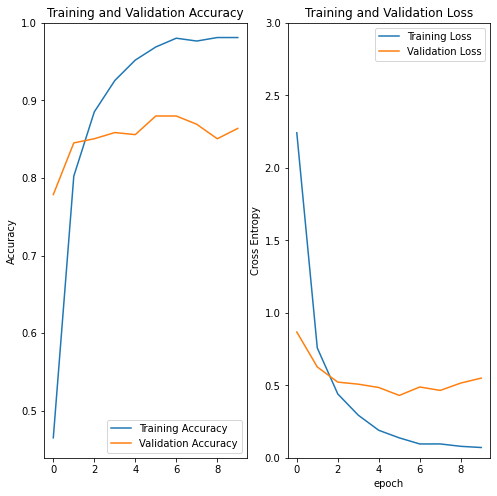

In [21]:
acc = augvgg16_history.history['accuracy']
val_acc = augvgg16_history.history['val_accuracy']

loss = augvgg16_history.history['loss']
val_loss = augvgg16_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
print("[INFO] Calculating model accuracy")
scores = augvgg16_model.evaluate(test_dataset)
print(f"Test Accuracy: {scores[1]*100}%")

[INFO] Calculating model accuracy
12/12 [==============================] - 25s 2s/step - loss: 0.4678 - accuracy: 0.8933
Test Accuracy: 89.33333158493042%


1/1 [==============================] - 0s 212ms/step
This image most likely belongs to ADONIS with a 89.33 percent confidence.
ADONIS


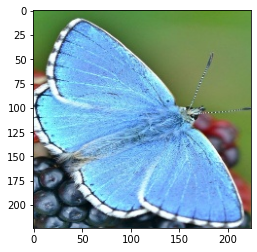

In [23]:
classes=list(train_dataset.class_indices.keys())
# Pre-Processing test data same as train data.
def prepare(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
    x = tf.keras.utils.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
img_url=r'data_dir/6 images/4.jpg'
result_augvgg16= augvgg16_model.predict([prepare(img_url)])
butterfly=tf.keras.utils.load_img(img_url)
plt.imshow(butterfly)

classresult=np.argmax(result_augvgg16,axis=1)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(classes[classresult[0]], 100 * np.max(scores))
)
print(classes[classresult[0]])

In [24]:
augvgg16_model.save('augvgg16_model.h5')

In [25]:
vgg16base_model.trainable = True

In [26]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(vgg16base_model.layers))

Number of layers in the base model:  19


In [27]:
# Fine-tune from this layer onwards
fine_tune_at = 17

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg16base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [28]:
base_learning_rate = 0.0005

augvgg16_model.compile(loss='categorical_crossentropy', 
                       optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10), 
                       metrics=['accuracy'])  

augvgg16_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 4, 4, 512)         0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 75)                19275     
                                                                 
Total params: 16,831,371
Trainable params: 4,476,491
Non-tr

In [29]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

tunedvgg16_history = augvgg16_model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=augvgg16_history.epoch[-1],
    validation_data=val_dataset,
    verbose=1
)

Epoch 10/20
291/291 [==============================] - 3604s 12s/step - loss: 0.0426 - accuracy: 0.9891 - val_loss: 0.4595 - val_accuracy: 0.8907
Epoch 11/20
291/291 [==============================] - 4219s 15s/step - loss: 0.0235 - accuracy: 0.9958 - val_loss: 0.4259 - val_accuracy: 0.9040
Epoch 12/20
291/291 [==============================] - 606s 2s/step - loss: 0.0243 - accuracy: 0.9945 - val_loss: 0.4532 - val_accuracy: 0.8960
Epoch 13/20
291/291 [==============================] - 596s 2s/step - loss: 0.0215 - accuracy: 0.9958 - val_loss: 0.4723 - val_accuracy: 0.8933
Epoch 14/20
291/291 [==============================] - 572s 2s/step - loss: 0.0172 - accuracy: 0.9970 - val_loss: 0.5844 - val_accuracy: 0.8773
Epoch 15/20
291/291 [==============================] - 540s 2s/step - loss: 0.0155 - accuracy: 0.9966 - val_loss: 0.4271 - val_accuracy: 0.9040
Epoch 16/20
291/291 [==============================] - 529s 2s/step - loss: 0.0110 - accuracy: 0.9976 - val_loss: 0.5223 - val_accur

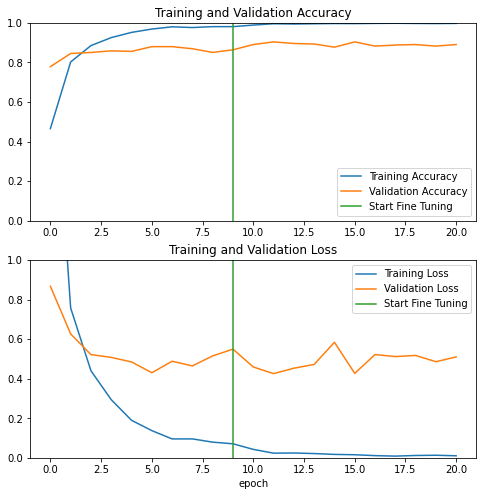

In [30]:
acc += tunedvgg16_history.history['accuracy']
val_acc += tunedvgg16_history.history['val_accuracy']

loss += tunedvgg16_history.history['loss']
val_loss += tunedvgg16_history.history['val_loss']

epochs_range = range(total_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
print("[INFO] Calculating model accuracy")
scores = augvgg16_model.evaluate(test_dataset)
print(f"Test Accuracy: {scores[1]*100}%")

[INFO] Calculating model accuracy
12/12 [==============================] - 20s 2s/step - loss: 0.4953 - accuracy: 0.9067
Test Accuracy: 90.66666960716248%


1/1 [==============================] - 0s 314ms/step
This image most likely belongs to ADONIS with a 90.67 percent confidence.


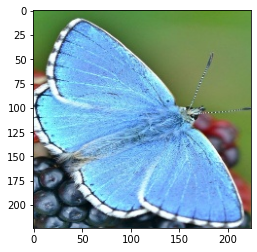

In [32]:
classes=list(train_dataset.class_indices.keys())
# Pre-Processing test data same as train data.
def prepare(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
    x = tf.keras.utils.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
img_url=r'data_dir/6 images/4.jpg'
result_basevgg16= augvgg16_model.predict([prepare(img_url)])
butterfly=tf.keras.utils.load_img(img_url)
plt.imshow(butterfly)

classresult=np.argmax(result_basevgg16,axis=1)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(classes[classresult[0]], 100 * np.max(scores))
)


In [33]:
augvgg16_model.save('tunedvgg16_model.h5')